In [80]:
import numpy as np
import h5py
import tensorflow.compat.v1 as tf 
from tensorflow.python.framework import ops
tf.disable_v2_behavior()
import tf_utils
import time
import matplotlib.pyplot as plt

Y = 1
训练集样本数 = 1080
测试集样本数 = 120
X_train.shape: (12288, 1080)
Y_train.shape: (6, 1080)
X_test.shape: (12288, 120)
Y_test.shape: (6, 120)


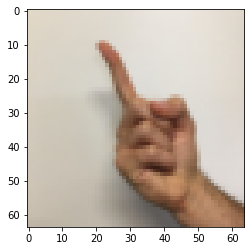

In [97]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()
index = 11
plt.imshow(X_train_orig[index])
print("Y = " + str(np.squeeze(Y_train_orig[:,index])))
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T #每一列就是一个样本
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T

#归一化数据
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255

#转换为独热矩阵
Y_train = tf_utils.convert_to_one_hot(Y_train_orig,6)
Y_test = tf_utils.convert_to_one_hot(Y_test_orig,6)

print("训练集样本数 = " + str(X_train.shape[1]))
print("测试集样本数 = " + str(X_test.shape[1]))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

In [105]:
def create_placeholders(n_x,n_y):
    """
    为TensorFlow会话创建占位符
    参数：
        n_x - 一个实数，图片向量的大小（64*64*3 = 12288）
        n_y - 一个实数，分类数（从0到5，所以n_y = 6）
    
    返回：
        X - 一个数据输入的占位符，维度为[n_x, None]，dtype = "float"
        Y - 一个对应输入的标签的占位符，维度为[n_Y,None]，dtype = "float"
    
    提示：
        使用None，因为它让我们可以灵活处理占位符提供的样本数量。事实上，测试/训练期间的样本数量是不同的。
    
    """
    
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [112]:
def initialize_parameters():
    """
    初始化神经网络的参数，参数的维度如下：
        W1 : [25, 12288]
        b1 : [25, 1]
        W2 : [12, 25]
        b2 : [12, 1]
        W3 : [6, 12]
        b3 : [6, 1]
    
    返回：
        parameters - 包含了W和b的字典
    
    
    """
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[25,12288],initializer = tf.glorot_uniform_initializer(seed=1))
    b1 = tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.glorot_uniform_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.glorot_uniform_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters

In [125]:
def forward_propagation(X,parameters):
    """
    实现一个模型的前向传播，模型结构为LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    参数：
        X - 输入数据的占位符，维度为（输入节点数量，样本数量）
        parameters - 包含了W和b的参数的字典
    
    返回：
        Z3 - 最后一个LINEAR节点的输出
    
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #Z1 = tf.add(tf.matmul(W1,X),b1)        # Z1 = np.dot(W1, X) + b1
    Z1 = tf.matmul(W1,X) + b1             #也可以这样写
    A1 = tf.nn.relu(Z1)                    # A1 = relu(Z1)
    #Z2 = tf.add(tf.matmul(W2, A1), b2)     # Z2 = np.dot(W2, a1) + b2
    Z2 = tf.matmul(W2,A1) + b2
    A2 = tf.nn.relu(Z2)                    # A2 = relu(Z2)
    #Z3 = tf.add(tf.matmul(W3, A2), b3)     # Z3 = np.dot(W3,Z2) + b3
    Z3 = tf.matmul(W3,A2) + b3
    
    
    return Z3

In [126]:
def compute_cost(Z3,Y):
    """
    计算成本
    
    参数：
        Z3 - 前向传播的结果
        Y - 标签，一个占位符，和Z3的维度相同
        
    返回：
        cost - 成本值
    
    
    """
    logits = tf.transpose(Z3) #转置
    labels = tf.transpose(Y)  #转置
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [129]:
def model(X_train,Y_train,X_test,Y_test,
		learning_rate=0.0001,num_epochs=1500,minibatch_size=64,
		print_cost=True,is_plot=True):
    """
    实现一个三层的TensorFlow神经网络：LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
    
    参数：
        X_train - 训练集，维度为（输入大小（输入节点数量） = 12288, 样本数量 = 1080）
        Y_train - 训练集分类数量，维度为（输出大小(输出节点数量) = 6, 样本数量 = 1080）
        X_test - 测试集，维度为（输入大小（输入节点数量） = 12288, 样本数量 = 120）
        Y_test - 测试集分类数量，维度为（输出大小(输出节点数量) = 6, 样本数量 = 120）
        learning_rate - 学习速率
        num_epochs - 整个训练集的遍历次数
        mini_batch_size - 每个小批量数据集的大小
        print_cost - 是否打印成本，每100代打印一次
        is_plot - 是否绘制曲线图
    
    返回：
        parameters - 学习后的参数

    """
    ops.reset_default_graph()                #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)
    seed = 3
    (n_x , m)  = X_train.shape               #获取输入节点数量和样本数
    n_y = Y_train.shape[0]                   #获取输出节点数量
    costs = []                               #成本集
    
    #给X, Y 创建placeholder
    X, Y = create_placeholders(n_x, n_y)
    
    #初始化参数
    parameters = initialize_parameters()
    
    #前向传播
    Z3 = forward_propagation(X,parameters)
    
    #计算成本
    cost = compute_cost(Z3,Y)
    
    #反向传播，使用Adam优化
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #初始化所有的变量
    init = tf.global_variables_initializer()
    
    #开始会话并计算
    with tf.Session() as sess:
        #初始化
        sess.run(init)
        
        #训练的循环
        for epoch in range(num_epochs):
            
            epoch_cost = 0 #每代的成本
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = tf_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                #选择一个minibatch
                (minibatch_X,minibatch_Y) = minibatch
                
                #数据已经准备好了，开始运行session
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                #计算这个minibatch在这一代中所占的误差
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches
                
            #记录成本
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                #是否打印
                if print_cost and epoch % 100 == 0:
                    print("epoch = " + str(epoch) + "   epoch_cost = " + str(epoch_cost))
        if is_plot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
        
        #保存学习后的参数
        parameters = sess.run(parameters)
        print("参数已经保存至session.")
        
        #计算当前的预测结果
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        
        #计算精准率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        
        print("训练集的准确率: ", accuracy.eval({X:X_train,Y:Y_train}))
        print("测试集的准确率: ", accuracy.eval({X:X_test,Y:Y_test}))
    
        return parameters

C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


epoch = 0   epoch_cost = 1.899366021156311
epoch = 100   epoch_cost = 1.1781471595168114
epoch = 200   epoch_cost = 0.7426812462508678
epoch = 300   epoch_cost = 0.48800497502088547
epoch = 400   epoch_cost = 0.33345762081444263
epoch = 500   epoch_cost = 0.23194941598922014
epoch = 600   epoch_cost = 0.1501698223873973
epoch = 700   epoch_cost = 0.1016568245831877
epoch = 800   epoch_cost = 0.06709859380498528
epoch = 900   epoch_cost = 0.04474988381844014
epoch = 1000   epoch_cost = 0.029049357282929122
epoch = 1100   epoch_cost = 0.01817315531661734
epoch = 1200   epoch_cost = 0.011519756313646212
epoch = 1300   epoch_cost = 0.00730187157751061
epoch = 1400   epoch_cost = 0.003870443906635046


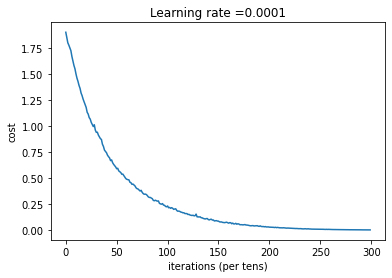

参数已经保存至session.
训练集的准确率:  1.0
测试集的准确率:  0.8833333
CPU的执行时间 = 261.3988004000057 秒


C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [130]:
#开始时间
start_time = time.clock()
#开始训练
parameters = model(X_train, Y_train, X_test, Y_test)
#结束时间
end_time = time.clock()
#计算时差
print("CPU的执行时间 = " + str(end_time - start_time) + " 秒" )